In [2]:
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras import layers 
from tensorflow.keras import Model 
import keras
import time
import pandas as pd
from tqdm import tqdm, trange
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [4]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
n_clean_noisy = n_img - n_noisy
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'/Users/christopherhalim888/Downloads/train_data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('/Users/christopherhalim888/Downloads/train_data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('/Users/christopherhalim888/Downloads/train_data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


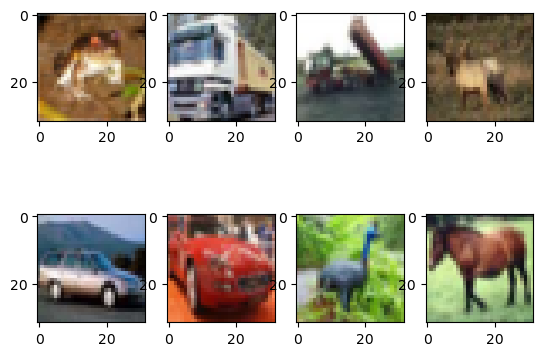

In [5]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [6]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [7]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [8]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2. Model I

Convolutional Neural Network (CNN or ConvNet) is a subtype of Neural Networks (NN) which is mainly used for image applications. Convolutional layer reduces the high dimensionality of images without losing important information.

For the given dataset, we implement a CNN model as described below. The CNN model starts with a first single convolutional layer. Then followed by one pair of dense block — transition block pair, and a second dense block. Dense block is a module that connects all layers (with matching feature-map sizes) directly with each other. Transition block between two dense blocks acts as a down sample operation, reducing the number of feature maps and the feature maps size to half.

And then the model is followed by the global average pooling layer to flatten the output feature. Finally, the flattened vector is feeded to the dense layer to do classification.

In [9]:
# Assign Required Variables
X_train = tf.cast(imgs, dtype='float32')/255.0
y_train = tf.one_hot(noisy_labels, depth=10)
X_test = tf.cast(imgs[:10000], dtype='float32')/255.0
X_test_img = imgs[:10000]
y_test = tf.one_hot(clean_labels, depth = 10)

2022-11-02 15:05:37.544294: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# [BUILD A MORE SOPHISTICATED PREDICTIVE MODEL]

def bn_relu_convolution(x, nb_channels, dropout_rate=None, bottleneck=False, weight_decay=1e-4):
    """
    Creates a convolution layers consisting of BN-ReLU-Conv.    
    """
    # Bottleneck
    if bottleneck:
        bottleneckWidth = 4
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)
        x = layers.Conv2D(nb_channels * bottleneckWidth, (1, 1),
                          kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)
        # Dropout
        if dropout_rate:
            x = layers.Dropout(dropout_rate)(x)

    # BN-ReLU-Conv
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(nb_channels, (3, 3), padding='same')(x)

    # Dropout
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    return x

def transition_block(x, nb_channels, dropout_rate=None, compression=1.0, weight_decay=1e-4):
    """
    Create a transition block between dense blocks, which consists convolution and pooling.
    """

    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu',)(x)
    x = layers.Convolution2D(int(nb_channels * compression), (1, 1), padding='same',
                             kernel_regularizer=tf.keras.regularizers.l2(weight_decay))(x)

    # Add dropout
    if dropout_rate:
        x = layers.Dropout(dropout_rate)(x)

    x = layers.AveragePooling2D((2, 2), strides=(2, 2))(x)

    return x


def dense_block(x, num_layers, nb_channels, growth_rate, dropout_rate=None, bottleneck=False,
                weight_decay=1e-4):
    """
    Create a dense block and concatenates inputs
    """

    for i in range(num_layers):
        cb = bn_relu_convolution(x, growth_rate, dropout_rate, bottleneck)
        nb_channels += growth_rate
        x = layers.concatenate([cb, x])

    return x, nb_channels


def ModelI(input_shape, dense_blocks, dense_layers, growth_rate, compression, bottleneck, 
            weight_decay, dropout_rate, num_classes):
    """
    Build the model
    """

    # Input
    img_input = layers.Input(shape=input_shape, name = 'img_input')
    nb_channels = growth_rate

    # First convolution layer
    x = layers.Conv2D(2 * growth_rate, (3, 3), padding='same', strides=(2, 2),name='input_conv', 
                      kernel_regularizer= tf.keras.regularizers.l2(weight_decay))(img_input)

    # Building dense blocks
    for block in range(dense_blocks - 1):
        # Add dense_block
        x, nb_channels = dense_block(x, dense_layers[block], nb_channels, growth_rate,
                                 dropout_rate, bottleneck, weight_decay) 

        # Add transition_block
        x = transition_block(x, nb_channels, dropout_rate, compression, weight_decay) # 1 conv layer
        nb_channels = int(nb_channels * compression)

    # Add last dense block without transition but with global average pooling
    x, nb_channels = dense_block(x, dense_layers[-1], nb_channels,
                                      growth_rate, dropout_rate, weight_decay)
    
    x = layers.BatchNormalization(name = 'prediction_bn')(x)
    x = layers.Activation('relu',  name = 'prediction_relu', )(x)
    x = layers.GlobalAveragePooling2D( name = 'prediction_pool', )(x)

    # Prediction of class
    prediction = layers.Dense(num_classes, name = 'prediction_dense', activation='softmax')(x)

    return tf.keras.Model(inputs=img_input, outputs=prediction, name='densenet')


def model1():
    start_time = time.time()
    
    # build CNN Model
    modelI = ModelI((32,32,3), dense_blocks = 2, dense_layers = [3]*2,
                    growth_rate = 4, compression = 0.5, num_classes = 10, bottleneck = False, 
                    dropout_rate = None, weight_decay = 1e-8)
        
    modelI.compile(optimizer = tf.keras.optimizers.Adam(0.0005),
                 #categoricalCrossentropy here decides that CNN is used
                 loss = tf.keras.losses.CategoricalCrossentropy(),
                 metrics = ['accuracy'])
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10)

    class TimeHistory(keras.callbacks.Callback):
        def on_train_begin(self, logs={}):
            self.times = []

        def on_epoch_begin(self, epoch, logs={}):
            self.epoch_time_start = time.time()

        def on_epoch_end(self, epoch, logs={}):
            self.times.append(time.time() - self.epoch_time_start)

    time_callback = TimeHistory()
    
    #modelI.fit(X_train, y_train, batch_size=128, epochs=50,
         # validation_split=0.2, callbacks=[early_stop, time_callback])
    modelI.fit(X_train, y_train, batch_size=128, epochs=100,
          validation_split=0.2, callbacks=[early_stop, time_callback])
    print("--- model took %s seconds ---" % (time.time() - start_time))
    
    return(modelI)

In [11]:
modelI = model1()

Epoch 1/100
313/313 [==============================] - 39s 121ms/step - loss: 2.2983 - accuracy: 0.1335 - val_loss: 2.2864 - val_accuracy: 0.1324
Epoch 2/100
313/313 [==============================] - 35s 111ms/step - loss: 2.2661 - accuracy: 0.1641 - val_loss: 2.2618 - val_accuracy: 0.1612
Epoch 3/100
313/313 [==============================] - 36s 115ms/step - loss: 2.2553 - accuracy: 0.1750 - val_loss: 2.2607 - val_accuracy: 0.1658
Epoch 4/100
313/313 [==============================] - 35s 112ms/step - loss: 2.2490 - accuracy: 0.1820 - val_loss: 2.2520 - val_accuracy: 0.1799
Epoch 5/100
313/313 [==============================] - 35s 111ms/step - loss: 2.2430 - accuracy: 0.1883 - val_loss: 2.2560 - val_accuracy: 0.1801
Epoch 6/100
313/313 [==============================] - 34s 110ms/step - loss: 2.2382 - accuracy: 0.1954 - val_loss: 2.2607 - val_accuracy: 0.1731
Epoch 7/100
313/313 [==============================] - 34s 110ms/step - loss: 2.2342 - accuracy: 0.1991 - val_loss: 2.2420 -

In [12]:
def model_I(image):
    # Data Normalization
    image = tf.cast(image, dtype='float32')/255.0
    prelabel = modelI.predict(image[np.newaxis,...], verbose=0)
    # Convert From One Hot Vector to Scalar
    maxlabel = np.argmax(prelabel)
    return(maxlabel)

In [13]:
modelI.save('model1.h5')

In [14]:
modelI = load_model('model1.h5')

### 2.3. Model II

The idea behing model2 is to use model 1 to classify noisy images and then use the output to train model 2. For model2, we use conv2D layer to learn a total of 32 filters first, followed by 64 filters, and then we use max pooling to reduce the spatial dimension of the output volume. We also included batch normalization layer in our model to make the training faster and improve the performance of our model. While training model2, we use Image Data Generator to increase the number of images in our dataset to have a bettwe accuracy

In [15]:
x_train_tot = tf.cast(imgs, dtype='float32')/255.0
crct_label_encode = modelI.predict(x_train_tot)
crct_label = np.argmax(crct_label_encode, axis=1)
noisy_label_crct = tf.one_hot(crct_label, depth=10)

In [16]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_categorical_accuracy', patience=8)

model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters = 32, kernel_size=(3,3), strides=1,
                           padding = 'same', use_bias = False,
                           activation = None, input_shape = (32,32,3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2),
    tf.keras.layers.Conv2D(filters = 64, kernel_size=(3,3), strides=1,
                           padding = 'same', use_bias = False,
                           activation = None),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2), strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation = None, use_bias = False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation('relu'),
    tf.keras.layers.Dense(10, activation='softmax')

])


model2.compile(optimizer=Adam(learning_rate=0.001, decay=1e-4),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), # True: outputs are not probs
              metrics=[tf.keras.metrics.CategoricalAccuracy()]
              )

model2.fit(x_train_tot, noisy_label_crct, batch_size=32, epochs=50, 
           validation_split=0.2, callbacks=[callback])



Epoch 1/50


/Users/christopherhalim888/opt/anaconda3/lib/python3.8/site-packages/tensorflow/python/util/dispatch.py:1096: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


1250/1250 [==============================] - 47s 37ms/step - loss: 1.0764 - categorical_accuracy: 0.6093 - val_loss: 1.1356 - val_categorical_accuracy: 0.5899
Epoch 2/50
1250/1250 [==============================] - 48s 39ms/step - loss: 0.8991 - categorical_accuracy: 0.6636 - val_loss: 0.8719 - val_categorical_accuracy: 0.6754
Epoch 3/50
1250/1250 [==============================] - 41s 33ms/step - loss: 0.8172 - categorical_accuracy: 0.6938 - val_loss: 1.1059 - val_categorical_accuracy: 0.5901
Epoch 4/50
1250/1250 [==============================] - 40s 32ms/step - loss: 0.7540 - categorical_accuracy: 0.7170 - val_loss: 0.9909 - val_categorical_accuracy: 0.6393
Epoch 5/50
1250/1250 [==============================] - 41s 33ms/step - loss: 0.6862 - categorical_accuracy: 0.7434 - val_loss: 1.0628 - val_categorical_accuracy: 0.6203
Epoch 6/50
1250/1250 [==============================] - 41s 33ms/step - loss: 0.6256 - categorical_accuracy: 0.7670 - val_loss: 0.9790 - val_categorical_accuracy

In [17]:
X_train = x_train_tot[:40000]
X_val = x_train_tot[40001:]
y_train = noisy_label_crct[:40000]
y_val = noisy_label_crct[40001:]

In [18]:
aug = ImageDataGenerator()

aug = ImageDataGenerator( rotation_range=30, zoom_range=0.15, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15, horizontal_flip=True, fill_mode="nearest")

aug.fit(X_train)

start = time.time()

model2.fit( aug.flow(X_train, y_train, batch_size=32), 
           validation_data=(X_val, y_val), epochs=50,  
           callbacks=[callback])

end = time.time()

Epoch 1/50
1250/1250 [==============================] - 43s 34ms/step - loss: 1.2746 - categorical_accuracy: 0.5623 - val_loss: 1.5907 - val_categorical_accuracy: 0.4943
Epoch 2/50
1250/1250 [==============================] - 48s 39ms/step - loss: 1.1234 - categorical_accuracy: 0.5894 - val_loss: 1.0116 - val_categorical_accuracy: 0.6287
Epoch 3/50
1250/1250 [==============================] - 80s 64ms/step - loss: 1.0955 - categorical_accuracy: 0.5989 - val_loss: 1.0267 - val_categorical_accuracy: 0.6323
Epoch 4/50
1250/1250 [==============================] - 74s 59ms/step - loss: 1.0815 - categorical_accuracy: 0.6003 - val_loss: 1.0220 - val_categorical_accuracy: 0.6232
Epoch 5/50
1250/1250 [==============================] - 74s 59ms/step - loss: 1.0686 - categorical_accuracy: 0.6058 - val_loss: 1.0398 - val_categorical_accuracy: 0.6201
Epoch 6/50
1250/1250 [==============================] - 66s 53ms/step - loss: 1.0605 - categorical_accuracy: 0.6065 - val_loss: 1.1383 - val_categoric

In [19]:
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    image = tf.cast(image, dtype='float32')/255.0
    #prelabel = modelI.predict(image[np.newaxis,...], verbose=0)
    pred = model2.predict(image[np.newaxis,...], verbose=0)
    maxlabel = np.argmax(pred)
    return maxlabel

In [21]:
model2.save('model_fin.h5')

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [22]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

In [23]:
# Baseline model Evaluation
start_time = time.time()
evaluation(baseline_model, clean_labels, X_test_img)
print("--- evaluation took %s seconds ---" % (time.time() - start_time))

              precision    recall  f1-score   support

           0       0.32      0.43      0.37      1005
           1       0.18      0.29      0.22       974
           2       0.22      0.04      0.07      1032
           3       0.19      0.12      0.14      1016
           4       0.24      0.48      0.32       999
           5       0.22      0.13      0.16       937
           6       0.26      0.35      0.30      1030
           7       0.29      0.04      0.07      1001
           8       0.28      0.43      0.34      1025
           9       0.19      0.11      0.14       981

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000

--- evaluation took 7.878995895385742 seconds ---


In [24]:
# Model 1 Evaluation
start_time = time.time()
evaluation(model_I, clean_labels, X_test_img)
print("--- evaluation took %s seconds ---" % (time.time() - start_time))

              precision    recall  f1-score   support

           0       0.51      0.44      0.47      1005
           1       0.59      0.54      0.57       974
           2       0.39      0.14      0.20      1032
           3       0.38      0.18      0.24      1016
           4       0.32      0.53      0.40       999
           5       0.41      0.29      0.34       937
           6       0.53      0.70      0.60      1030
           7       0.51      0.56      0.53      1001
           8       0.52      0.68      0.59      1025
           9       0.46      0.58      0.51       981

    accuracy                           0.46     10000
   macro avg       0.46      0.46      0.45     10000
weighted avg       0.46      0.46      0.45     10000

--- evaluation took 443.89392614364624 seconds ---


In [25]:
# Model 2 Evaluation
start_time = time.time()
evaluation(model_II, clean_labels, X_test_img)
print("--- evaluation took %s seconds ---" % (time.time() - start_time))

              precision    recall  f1-score   support

           0       0.58      0.42      0.48      1005
           1       0.62      0.59      0.61       974
           2       0.54      0.04      0.08      1032
           3       0.43      0.09      0.15      1016
           4       0.35      0.26      0.30       999
           5       0.49      0.21      0.29       937
           6       0.34      0.89      0.49      1030
           7       0.53      0.62      0.57      1001
           8       0.62      0.62      0.62      1025
           9       0.38      0.79      0.52       981

    accuracy                           0.45     10000
   macro avg       0.49      0.45      0.41     10000
weighted avg       0.49      0.45      0.41     10000

--- evaluation took 459.8165559768677 seconds ---


In [ ]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evaluation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

In [ ]:
# Model 1 Evaluation on Test Data Set
evaluation(model_I, test_labels, test_imgs)

In [ ]:
# Model 2 Evaluation on Test Data Set
evaluation(model_II, test_labels, test_imgs)

The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

## 4. Prediction on the test image data